In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
init_printing()

In [2]:
# def graph(adj_matrix):
#     # Find number of rows/columns (since the matrix is square)
#     N = len(adj_matrix)
#     # Establish variables to plot out the circle
#     R = 5
#     X = []
#     Y = []
#     Z = np.linspace(1, N, N)
#     # Plot out the circle   
#     for node in range(N):
#         theta = 2 * np.pi * node / N
#         X.append(R * np.cos(theta))
#         Y.append(R * np.sin(theta))
#     # Create the plots (to show the circle)
#     fig, ax = plt.subplots()
#     # Plot out the nodes of the graph
#     # This part looks through the adjacency matrix to find where the 
#     # nodes are in the graph. Once it has found the nodes, it looks
#     # to see where the edges should be, and draws them.
#     for i in range(N):
#         for j in range(i):
#             # This part just checks to see if the matrix is 
#             # symmetric.
#             if adj_matrix[i][j] == adj_matrix[j][i]:
#                 if adj_matrix[i][j] == 1:
#                     plt.plot([X[i], X[j]], [Y[i], Y[j]])
#                 else:
#                     continue
#             else:
#                 return "Error: Not an adjacency matrix."
  
#     # Always label our graphs :)
#     for i,j,k in zip(X, Y, Z):
#             ax.annotate("Node %i" %k, xy = (i,j), \
#             xytext = (30, 0), textcoords = "offset points")
    
#     # Show the graph
#     plt.show()

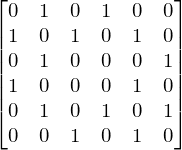

In [3]:
adj = np.array([[0,1,0,1,0,0],
                [1,0,1,0,1,0],
                [0,1,0,0,0,1],
                [1,0,0,0,1,0],
                [0,1,0,1,0,1],
                [0,0,1,0,1,0],])
Matrix(adj)

In [4]:
def laplacian(adj): return adj.sum(axis=1) * np.eye(adj.shape[0],dtype=np.int) + (adj * -1)
laplacian(adj)

array([[ 2, -1,  0, -1,  0,  0],
       [-1,  3, -1,  0, -1,  0],
       [ 0, -1,  2,  0,  0, -1],
       [-1,  0,  0,  2, -1,  0],
       [ 0, -1,  0, -1,  3, -1],
       [ 0,  0, -1,  0, -1,  2]])

In [46]:
from functools import reduce
from operator import add,mul
edges = [(0,3), (0,1), (3,4), (1,4), (1,2), (4,5), (2,5)]
def edges_to_incidence(edges,connect_to_inf=[]):
    distinct_vs = np.unique(reduce(add, [list(i) for i in edges],[]))
    n_nodes=len(distinct_vs)
    for ex in connect_to_inf: #this is a standard graph theory thing to create a planar extension connecting to infinity node
        infinity_node = distinct_vs.max() +1
        edges.append((ex,infinity_node))
    if len(connect_to_inf) > 0: n_nodes+=1
   
    inc = np.zeros((n_nodes,len(edges)),dtype=np.int)
    for i, e in enumerate(edges):
        inc[e[1],i] = 1
        inc[e[0],i] = -1    
        
    return inc

def incidence_to_laplacian(inc): return np.dot(inc,inc.T)
#todo edges from adj, edges to adj

inc = edges_to_incidence(edges)
inc

array([[-1, -1,  0,  0,  0,  0,  0],
       [ 0,  1,  0, -1, -1,  0,  0],
       [ 0,  0,  0,  0,  1,  0, -1],
       [ 1,  0, -1,  0,  0,  0,  0],
       [ 0,  0,  1,  1,  0, -1,  0],
       [ 0,  0,  0,  0,  0,  1,  1]])

In [47]:
edges

In [217]:
def connect_infinity_to_adj(mat,ex_vert=[]):
    """given an adjacency matrix, add an external infitity vertex connected to the external nodes"""
    mat = np.pad(adj, ((0,1), (0,1)), 'minimum')
    for v in ex_vert:
        mat[-1,v] = 1
        mat[v,-1] = 1
    
    return mat

def i_cofactor(mat,i=0):
    """remove ith row and ith column"""
    temp = mat.copy()
    temp = np.delete(temp,i,0)
    return np.delete(temp,i,1)

def sym_i_cofactor(mat,r=-1,c=-1):
    """remove ith row and ith column"""
    temp = Matrix(mat)
    if r==-1: r = temp.shape[0]-1
    if c==-1: c = temp.shape[1]-1
    #print("removing rows and cols", r,c)
    temp.col_del(c)
    temp.row_del(r)
    return temp

#def _spanning_tree()
def symbol_laplacian(inc,edges,external_edges=[]):
    external_start_index=-1
    if len(external_edges): external_start_index = len(edges) +1 - len(external_edges)
    #print("external edges start at", external_start_index)
    """This computes the input of Kirchoff polymial (reduced laplacian) in symbol form"""
    def _int_to_dummy(i):  
        if i >= external_start_index and external_start_index > 0: return Symbol("z")# +str(i)for testing we might care about which z
        return Symbol("x"+str(i))
    def _symbol_row_(vec,v):
        _ret = [0 for i in range(inc.shape[0])]
        entries = list(np.where(vec!=0)[0])
        """take the incident matrix and use the zero indexed enries to create dummy variables"""
        _ret[v] = reduce(add,[_int_to_dummy(i+1) for i in entries],0)
        #foreach entries, look at the inc column and find my adjoint
        for e in entries:
            adj = list(set(np.nonzero(inc[:,e])[0]) - set([v]))[0]
            _ret[adj] = -1*_int_to_dummy(1*(e+1))         
        return _ret
     
    return Matrix([_symbol_row_(row,v) for v, row in enumerate(inc)])

def kirchhoff_poly(edges,infinity_connect_list=[]):
    inc = edges_to_incidence(edges,connect_to_inf=infinity_connect_list)
    #this is true because we add some things to the end, and these are external - the are "zs"
    external_edges = edges[-len(infinity_connect_list):] if len(infinity_connect_list) > 0 else []
    #print("external edges", external_edges)
    #NB - need to know where the edges that are external "the zs" begins in the ordered list
    lap = symbol_laplacian(inc,edges,external_edges)
    #return lap
    reduced = sym_i_cofactor(lap)
    P= reduced.det(method='berkowitz')
    P = collect(expand(P),Symbol("z"))
    return P
    
def graph_polynomials(edges,infinity_connect_list=[],include_masses=False):
    max_ind = len(edges)
    S = kirchhoff_poly(edges,infinity_connect_list)
    
    #max index is what we use to determine the edge basis to devided out the terms from the kirchhoff polynomial
    #we get the first and second order from the generating polynomial
    U = __W__(S, order=1, max_index=max_ind)
    F0 = __W__(S, order=2, max_index=max_ind)
    NCM = compute_neg_cut_momenta()
    SUM_MASS = 0 if include_masses == False else reduce(add, [Symbol("x"+str(i)) *Symbol("m"+str(i))**2 for i in range(1,max_index+1)],1)
    F = F0
    return U, NCM * F + U * SUM_MASS
    
def __W__(P, max_index, order = 1):
    """This is a helper function that computes the inverted coefficients for the kirchoff polymial
    """
    
    def _inversion_(S):
        """This is actually a set complement"""
        pre_term = reduce(mul, [Symbol("x"+str(i)) for i in range(1,max_index+1)],1)
        return reduce(add , [((1/t)*pre_term).as_content_primitive()[-1] for t in S.args ], 0)

    return  _inversion_(P.coeff(Symbol("z"),order))
    
def compute_neg_cut_momenta():
    return 1

def spanning_trees(mat, removed_edges_out=[]):  pass
def k_forests(mat,k=2, removed_edges_out=[]):  pass

def vertex_conservation_equations(inc, choose_ks=[]):
    for v in inc.shape

In [209]:
#connect_infinity_to_adj(adj,[1])

In [214]:
edges = [(0,1), (1,3), (0,2), (3,2), (3,5), (2,4), (4,5)]
S = kirchhoff_poly(edges,[0,1,4,5])#
#s = __W__(S, order=1, max_index=7)
S
#s

In [213]:
graph_polynomials([(0,1), (1,3), (0,2), (3,2), (3,5), (2,4), (4,5)], 
                  [0,1,4,5])

In [284]:
edges = [(0,1), (1,3), (0,2), (3,2), (3,5), (2,4), (4,5)]
L = len(edges)
inc_fll = edges_to_incidence(edges,[0,1,4,5] )
E = len(edges) - L
fix_k = [2,5]
statements = []
keep_symbols = []
def smart_symbol(i):
    if i in fix_k: return Symbol("k"+str(i%2 + 1 ))
    if i >= L:  return Symbol("p"+str(i%L+1))#silly,assuming external spill is smaller than q list
    S = Symbol("q"+str(i+1))
    keep_symbols.append(S)
    return S
                
for row in inc_fll[:-1]:
    non_zero = list(np.where(row!=0)[0])
    s = reduce(add, [ smart_symbol(i) for i in non_zero],0)
    statements.append(Eq(s,0))
statements
#check the actually indexing for this example - have we got the right terms

In [287]:
#we want to write all the qs in terms of the non qs
solve(statements,list(set(keep_symbols)))

In [286]:
set(keep_symbols)